In [1]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("f1_data.db")

# Load essential tables
tyre_changes = pd.read_sql("SELECT * FROM tyre_changes", conn)
weather = pd.read_sql("SELECT * FROM weather", conn)
race_sessions = pd.read_sql("SELECT * FROM race_sessions", conn)
circuits = pd.read_sql("SELECT * FROM circuits", conn)

study how weather impacts tyre strategy, so aggregate weather data per race and merge it with the tyre_changes table.

In [12]:
race_sessions.session_key.unique()

array([ 7779,  7787,  7953,  9070,  9078,  9094,  9102,  9110,  9118,
        9126,  9133,  9141,  9149,  9157,  9165,  9173,  9181,  9189,
        9197,  9205,  9213,  9221,  9472,  9480,  9488,  9496,  9507,
        9515,  9523,  9531,  9539,  9550,  9558,  9566,  9574,  9582,
        9590,  9598,  9606,  9617,  9625,  9636,  9644,  9655,  9662,
        9673,  9693,  9869,  9877,  9888,  9896,  9904,  9912,  9920,
        9928,  9939,  9947,  9955,  9963,  9971,  9979,  9987,  9998,
       10006, 10014, 10022, 10033])

In [2]:
# Aggregate weather to get avg conditions per session
weather_avg = (
    weather.groupby("session_key")
    .agg({
        "wind_speed": "mean",
        "rainfall": "mean",
        "track_temperature": "mean",
        "air_temperature": "mean",
        "humidity": "mean",
        "pressure": "mean"
    })
    .reset_index()
)

# Join with tyre_changes
tyre_weather = tyre_changes.merge(weather_avg, on="session_key", how="left")


In [7]:
tyre_weather.head()

,driver,change_type,tyre_change_lap,laps_on_old_tyre,laps_on_new_tyre,pos_before,pos_after,position_change,Abnormal,lap_time_change,session_key,wind_speed,rainfall,track_temperature,air_temperature,humidity,pressure
0,1.0,MEDIUM->HARD,18.0,18.0,5.0,4.0,4.0,0.0,0,-3.43275,7779,1.772297,0.0,31.792568,26.091892,57.790541,1010.92973
1,2.0,HARD->MEDIUM,18.0,18.0,5.0,11.5,14.5,3.0,0,-12.61425,7779,1.772297,0.0,31.792568,26.091892,57.790541,1010.92973
2,4.0,SOFT->HARD,2.0,2.0,5.0,17.5,20.0,2.5,0,-6.99750,7779,1.772297,0.0,31.792568,26.091892,57.790541,1010.92973
3,4.0,HARD->MEDIUM,19.0,17.0,5.0,18.0,18.5,0.5,0,-31.72350,7779,1.772297,0.0,31.792568,26.091892,57.790541,1010.92973
4,10.0,MEDIUM->HARD,14.0,14.0,5.0,10.0,13.0,3.0,0,20.43825,7779,1.772297,0.0,31.792568,26.091892,57.790541,1010.92973


In [11]:
tyre_weather.session_key.unique()

array([ 7779,  7787,  7953,  9070,  9078,  9094,  9102,  9110,  9118,
        9126,  9133,  9141,  9149,  9157,  9165,  9173,  9181,  9189,
        9197,  9205,  9213,  9221,  9472,  9480,  9488,  9496,  9507,
        9515,  9523,  9531,  9539,  9550,  9558,  9566,  9574,  9582,
        9590,  9598,  9606,  9617,  9625,  9644,  9655,  9662,  9673,
        9869,  9877,  9888,  9896,  9904,  9912,  9920,  9928,  9939,
        9955,  9963,  9971,  9979,  9987,  9998, 10006, 10014, 10022,
       10033])

In [8]:
tyre_weather.columns

Index(['driver', 'change_type', 'tyre_change_lap', 'laps_on_old_tyre',
       'laps_on_new_tyre', 'pos_before', 'pos_after', 'position_change',
       'Abnormal', 'lap_time_change', 'session_key', 'wind_speed', 'rainfall',
       'track_temperature', 'air_temperature', 'humidity', 'pressure'],
      dtype='object')

1. Position Change by Compound Type

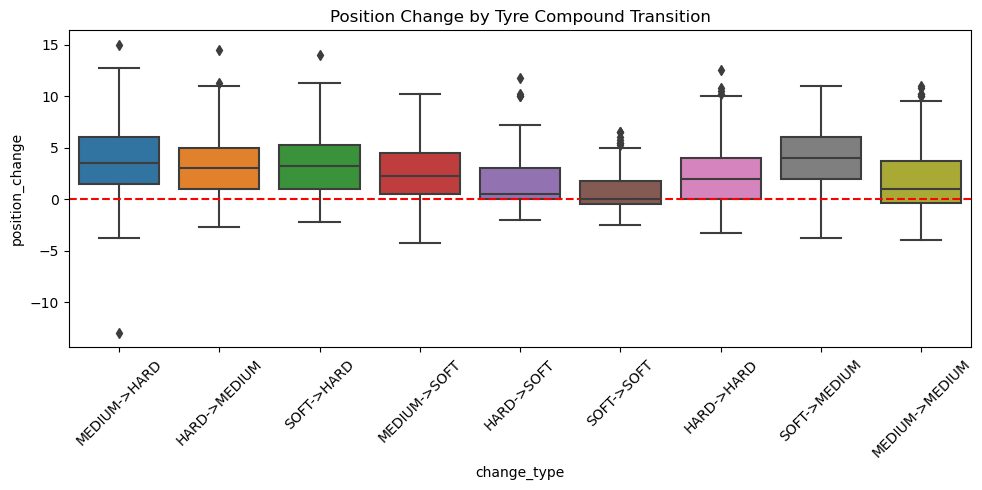

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=tyre_weather, x="change_type", y="position_change")
plt.xticks(rotation=45)
plt.title("Position Change by Tyre Compound Transition")
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


2. Faceted Lineplots (One Subplot per change_type)

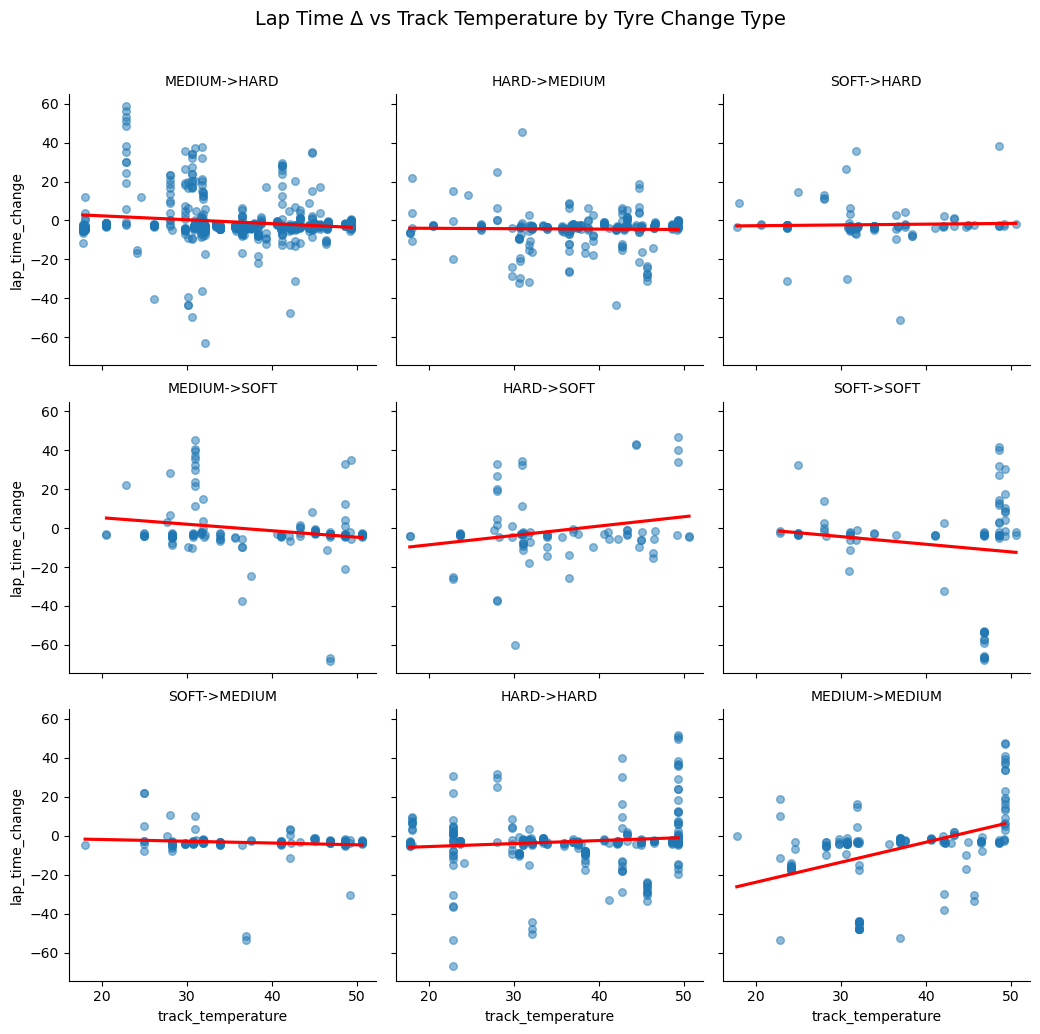

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: filter out extreme outliers
filtered = tyre_weather[
    tyre_weather["lap_time_change"].between(-100, 100)
].copy()

# Create faceted plot
g = sns.lmplot(
    data=filtered,
    x="track_temperature", y="lap_time_change",
    col="change_type", col_wrap=3,
    scatter_kws={'alpha':0.5, 's':30},
    line_kws={"color":"red"},
    ci=None, height=3.5
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Lap Time Δ vs Track Temperature by Tyre Change Type", fontsize=14)
plt.show()


3. Bar: Count of Tyre Change Types

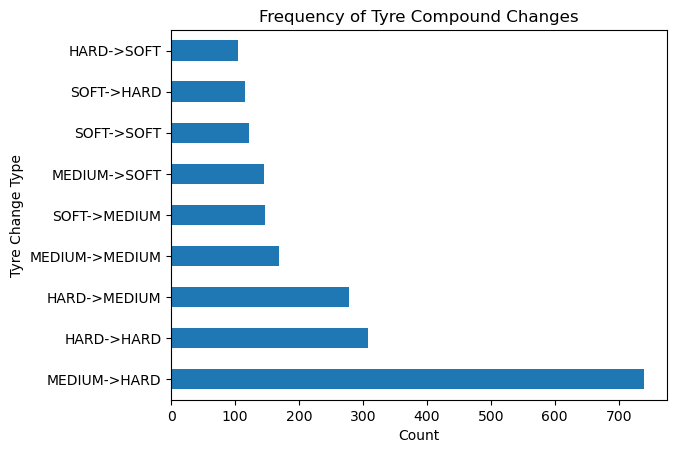

In [5]:
tyre_weather["change_type"].value_counts().plot(kind="barh")
plt.title("Frequency of Tyre Compound Changes")
plt.xlabel("Count")
plt.ylabel("Tyre Change Type")
plt.show()


In [13]:
driver_meta = pd.read_sql("""
    SELECT
        ds.driver_number,
        ds.session_key,
        ds.team_id,
        di.full_name,
        di.broadcast_name,
        t.team_name
    FROM driver_sessions AS ds
    LEFT JOIN drivers_identity AS di
        ON ds.driver_id = di.driver_id
    LEFT JOIN teams AS t
        ON ds.team_id = t.team_id
""", conn)

# One row per driver/session (just in case)
driver_meta = driver_meta.drop_duplicates(
    subset=["driver_number", "session_key"]
)

# Merge into tyre_weather
tyre_weather = tyre_weather.merge(
    driver_meta,
    left_on=["driver", "session_key"],   # 'driver' = driver_number in tyre_changes
    right_on=["driver_number", "session_key"],
    how="left"
)
tyre_weather = tyre_weather.drop(columns=["driver"])
tyre_weather.head()

,change_type,tyre_change_lap,laps_on_old_tyre,laps_on_new_tyre,pos_before,pos_after,position_change,Abnormal,lap_time_change,session_key,...,rainfall,track_temperature,air_temperature,humidity,pressure,driver_number,team_id,full_name,broadcast_name,team_name
0,MEDIUM->HARD,18.0,18.0,5.0,4.0,4.0,0.0,0,-3.43275,7779,...,0.0,31.792568,26.091892,57.790541,1010.92973,1,1,Max VERSTAPPEN,M VERSTAPPEN,Red Bull Racing
1,HARD->MEDIUM,18.0,18.0,5.0,11.5,14.5,3.0,0,-12.61425,7779,...,0.0,31.792568,26.091892,57.790541,1010.92973,2,7,Logan SARGEANT,L SARGEANT,Williams
2,SOFT->HARD,2.0,2.0,5.0,17.5,20.0,2.5,0,-6.99750,7779,...,0.0,31.792568,26.091892,57.790541,1010.92973,4,4,Lando NORRIS,L NORRIS,McLaren
3,HARD->MEDIUM,19.0,17.0,5.0,18.0,18.5,0.5,0,-31.72350,7779,...,0.0,31.792568,26.091892,57.790541,1010.92973,4,4,Lando NORRIS,L NORRIS,McLaren
4,MEDIUM->HARD,14.0,14.0,5.0,10.0,13.0,3.0,0,20.43825,7779,...,0.0,31.792568,26.091892,57.790541,1010.92973,10,5,Pierre GASLY,P GASLY,Alpine


In [14]:
race_circuit_meta = pd.read_sql("""
    SELECT
        rs.session_key,
        rs.year,
        rs.date_start,
        c.circuit_short_name,
        c.country_code
    FROM race_sessions AS rs
    LEFT JOIN circuits AS c
        ON rs.circuit_key = c.circuit_key
""", conn)

tyre_weather = tyre_weather.merge(
    race_circuit_meta,
    on="session_key",
    how="left"
)
tyre_weather.head()

,change_type,tyre_change_lap,laps_on_old_tyre,laps_on_new_tyre,pos_before,pos_after,position_change,Abnormal,lap_time_change,session_key,...,pressure,driver_number,team_id,full_name,broadcast_name,team_name,year,date_start,circuit_short_name,country_code
0,MEDIUM->HARD,18.0,18.0,5.0,4.0,4.0,0.0,0,-3.43275,7779,...,1010.92973,1,1,Max VERSTAPPEN,M VERSTAPPEN,Red Bull Racing,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA
1,HARD->MEDIUM,18.0,18.0,5.0,11.5,14.5,3.0,0,-12.61425,7779,...,1010.92973,2,7,Logan SARGEANT,L SARGEANT,Williams,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA
2,SOFT->HARD,2.0,2.0,5.0,17.5,20.0,2.5,0,-6.99750,7779,...,1010.92973,4,4,Lando NORRIS,L NORRIS,McLaren,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA
3,HARD->MEDIUM,19.0,17.0,5.0,18.0,18.5,0.5,0,-31.72350,7779,...,1010.92973,4,4,Lando NORRIS,L NORRIS,McLaren,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA
4,MEDIUM->HARD,14.0,14.0,5.0,10.0,13.0,3.0,0,20.43825,7779,...,1010.92973,10,5,Pierre GASLY,P GASLY,Alpine,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA


In [15]:
tyre_weather.columns

Index(['change_type', 'tyre_change_lap', 'laps_on_old_tyre',
       'laps_on_new_tyre', 'pos_before', 'pos_after', 'position_change',
       'Abnormal', 'lap_time_change', 'session_key', 'wind_speed', 'rainfall',
       'track_temperature', 'air_temperature', 'humidity', 'pressure',
       'driver_number', 'team_id', 'full_name', 'broadcast_name', 'team_name',
       'year', 'date_start', 'circuit_short_name', 'country_code'],
      dtype='object')

Which Teams Perform Best After Tyre Changes?

/var/folders/tr/5jh9bs_x48v4zmsym921ndb40000gn/T/ipykernel_13055/708635247.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=tyre_weather, x="team_name", y="position_change", ci=None)


Text(0.5, 1.0, 'Avg Position Change After Tyre Stop by Team')

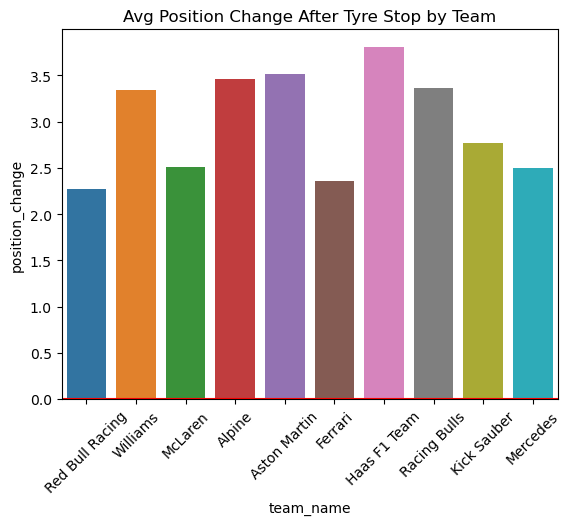

In [16]:
sns.barplot(data=tyre_weather, x="team_name", y="position_change", ci=None)
plt.axhline(0, color='red')
plt.xticks(rotation=45)
plt.title("Avg Position Change After Tyre Stop by Team")

Tyre Strategy by Circuit (Tracks With Most Pit Stops)

Text(0.5, 1.0, 'Number of Tyre Changes by Circuit')

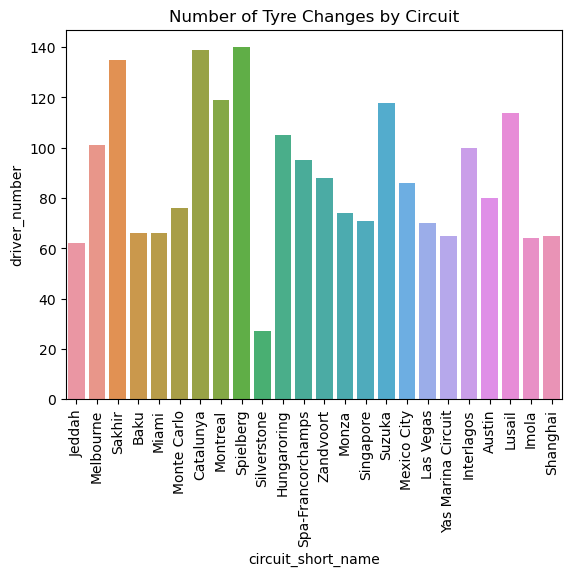

In [17]:
sns.barplot(data=tyre_weather, x="circuit_short_name", y="driver_number", estimator=len)
plt.xticks(rotation=90)
plt.title("Number of Tyre Changes by Circuit")  

Track Temperature vs Position Change (by Compound Type)

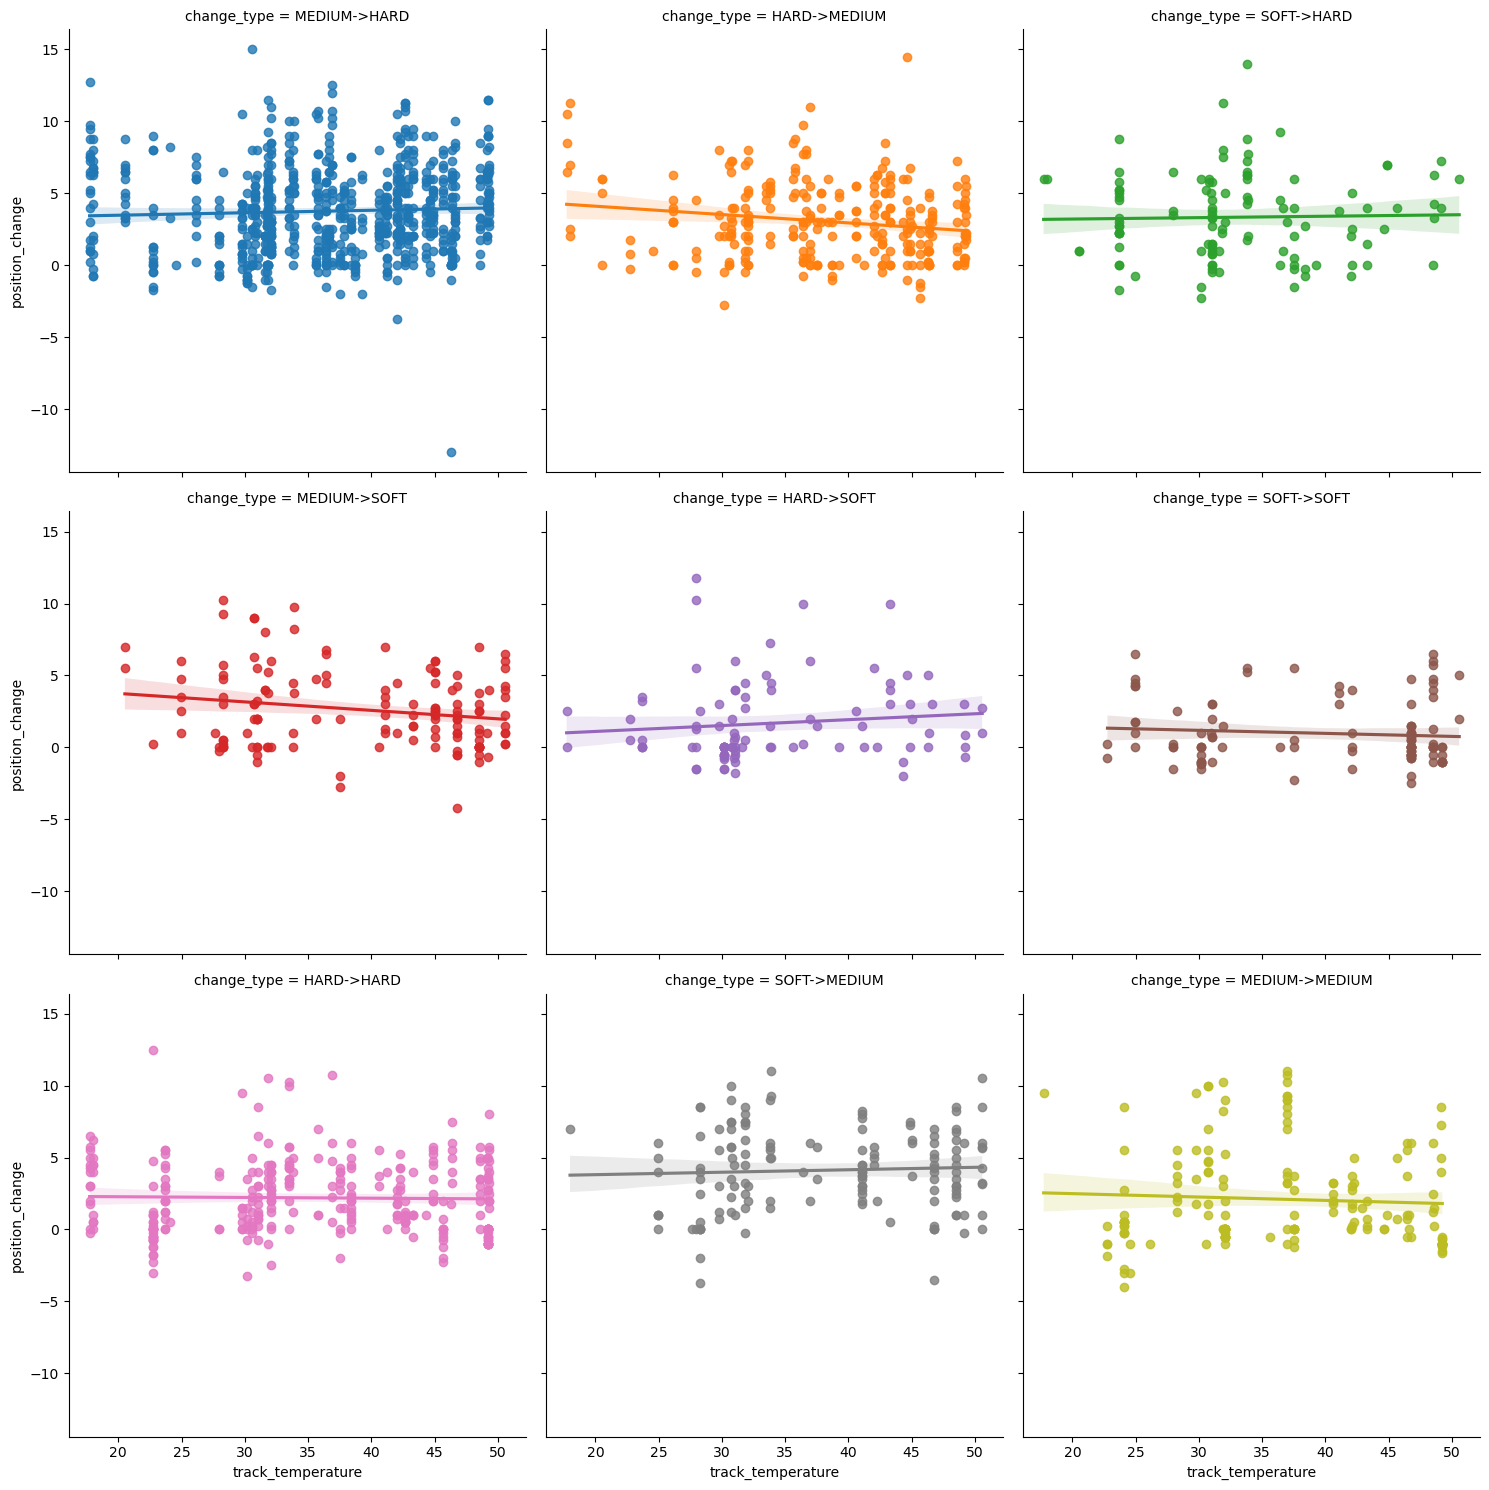

In [18]:
sns.lmplot(
    data=tyre_weather,
    x="track_temperature", y="position_change",
    hue="change_type", col="change_type", col_wrap=3
)


Who Is the Best Driver at Pitting (Most Negative position_change)?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'Max VERSTAPPEN'),
  Text(1, 0, 'Logan SARGEANT'),
  Text(2, 0, 'Lando NORRIS'),
  Text(3, 0, 'Pierre GASLY'),
  Text(4, 0, 'Sergio PEREZ'),
  Text(5, 0, 'Fernando ALONSO'),
  Text(6, 0, 'Charles LECLERC'),
  Text(7, 0, 'Lance STROLL'),
  Text(8, 0, 'Kevin MAGNUSSEN'),
  Text(9, 0, 'Nyck DE VRIES'),
  Text(10, 0, 'Yuki TSUNODA'),
  Text(11, 0, 'Alexander ALBON'),
  Text(12, 0, 'ZHOU Guanyu'),
  Text(13, 0, 'Nico HULKENBERG'),
  Text(14, 0, 'Esteban OCON'),
  Text(15, 0, 'Lewis HAMILTON'),
  Text(16, 0, 'Carlos SAINZ'),
  Text(17, 0, 'George RUSSELL'),
  Text(18, 0, 'Valtteri BOTTAS'),
  Text(19, 0, 'Oscar PIASTRI'),
  Text(20, 0, 'Daniel RICCIARDO'),
  Text(21, 0, 'Liam LAWSON'),
  Text(22, 0, 'Oliver BEARMAN'),
  Text(23, 0, 'Franco COLAPINTO'),
  Text(24, 0, 'Jack DOOHAN'),
  Text(25, 0, 'Isack HADJAR'),
  Text(26, 0, 'Kimi ANTONELLI'),
  Text

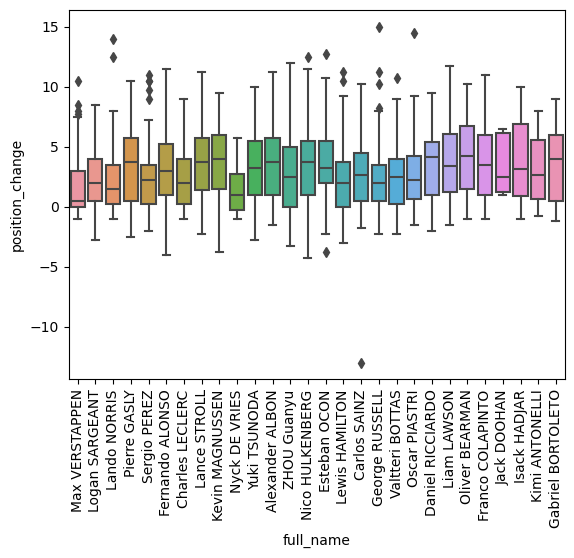

In [19]:
sns.boxplot(data=tyre_weather, x="full_name", y="position_change")
plt.xticks(rotation=90)


What Tyre Transitions Are Most Common?

In [25]:
results = pd.read_sql("SELECT * FROM results", conn)
results.head()

,session_key,position,driver_number,number_of_laps,points,duration,gap_to_leader,dnf,dns,dsq
0,7953,1.0,1,57.0,25,5636.736,0,0,0,0
1,7953,2.0,11,57.0,18,5648.723,11.987,0,0,0
2,7953,3.0,14,57.0,15,5675.373,38.637,0,0,0
3,7953,4.0,55,57.0,12,5684.788,48.052,0,0,0
4,7953,5.0,44,57.0,10,5687.713,50.977,0,0,0


In [26]:
tyre_weather_renamed = tyre_weather.rename(columns={"driver": "driver_number"})
strategy_results = tyre_weather_renamed.merge(
    results[["driver_number", "session_key", "position"]],
    on=["driver_number", "session_key"],
    how="left"
)
strategy_results.head()


,change_type,tyre_change_lap,laps_on_old_tyre,laps_on_new_tyre,pos_before,pos_after,position_change,Abnormal,lap_time_change,session_key,...,driver_number,team_id,full_name,broadcast_name,team_name,year,date_start,circuit_short_name,country_code,position
0,MEDIUM->HARD,18.0,18.0,5.0,4.0,4.0,0.0,0,-3.43275,7779,...,1,1,Max VERSTAPPEN,M VERSTAPPEN,Red Bull Racing,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA,2.0
1,HARD->MEDIUM,18.0,18.0,5.0,11.5,14.5,3.0,0,-12.61425,7779,...,2,7,Logan SARGEANT,L SARGEANT,Williams,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA,16.0
2,SOFT->HARD,2.0,2.0,5.0,17.5,20.0,2.5,0,-6.99750,7779,...,4,4,Lando NORRIS,L NORRIS,McLaren,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA,17.0
3,HARD->MEDIUM,19.0,17.0,5.0,18.0,18.5,0.5,0,-31.72350,7779,...,4,4,Lando NORRIS,L NORRIS,McLaren,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA,17.0
4,MEDIUM->HARD,14.0,14.0,5.0,10.0,13.0,3.0,0,20.43825,7779,...,10,5,Pierre GASLY,P GASLY,Alpine,2023,2023-03-19T17:00:00+00:00,Jeddah,KSA,9.0


How many tyre changes did each race winner make?

In [27]:
winners = strategy_results[strategy_results["position"] == 1]
changes_per_winner = winners.groupby("session_key")["change_type"].count()


Plot the distribution of tyre changes among winners

/Users/lisalei/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


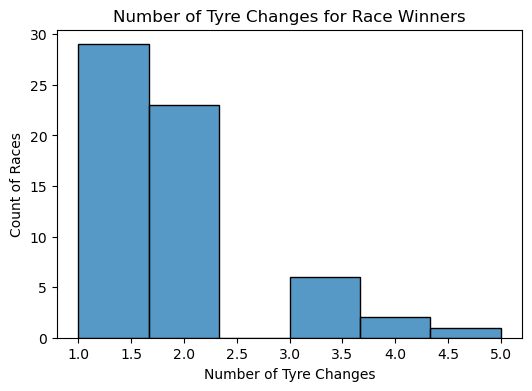

In [28]:
plt.figure(figsize=(6,4))
sns.histplot(changes_per_winner, bins=6, kde=False)
plt.title("Number of Tyre Changes for Race Winners")
plt.xlabel("Number of Tyre Changes")
plt.ylabel("Count of Races")
plt.show()


Average tyre changes by finishing position:

In [34]:
driver_col = "driver_number"   # or whatever you actually see

driver_changes = (
    strategy_results
    .groupby(["session_key", driver_col], as_index=False)["change_type"]
    .count()
    .rename(columns={"change_type": "n_tyre_changes"})
)

finishing_pos = (
    strategy_results[["session_key", driver_col, "position"]]
    .drop_duplicates()
)

driver_changes = driver_changes.merge(
    finishing_pos,
    on=["session_key", driver_col],
    how="left"
)


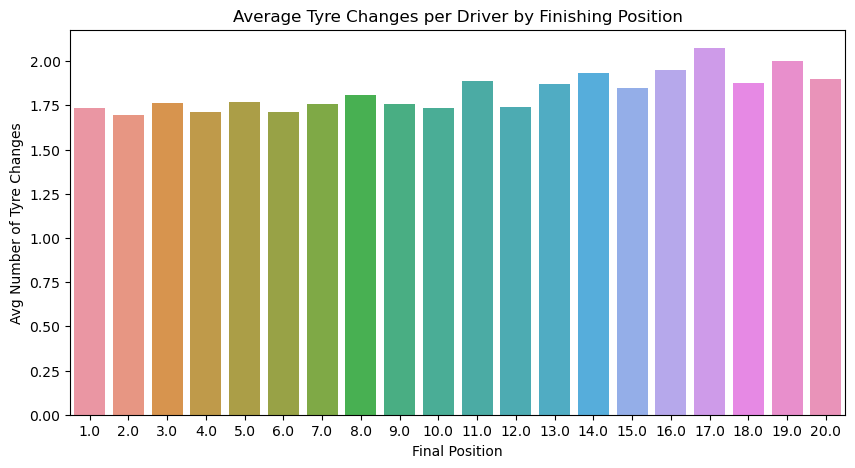

In [35]:
# average # tyre changes per driver per race by finishing position
avg_changes_by_pos = (
    driver_changes
    .groupby("position")["n_tyre_changes"]
    .mean()
    .sort_index()
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=avg_changes_by_pos.index, y=avg_changes_by_pos.values)
plt.title("Average Tyre Changes per Driver by Finishing Position")
plt.xlabel("Final Position")
plt.ylabel("Avg Number of Tyre Changes")
plt.show()


Identify last place finisher for each session

In [30]:
# Get last finisher (highest numerical position) per session
last_place = results.loc[
    results.groupby("session_key")["position"].idxmax()
][["session_key", "driver_number"]]
last_place.head()

,session_key,driver_number
37,7779,77
56,7787,20
16,7953,4
77,9070,77
99,9078,2


In [31]:
last_with_changes = last_place.merge(
    tyre_weather_renamed,
    on=["session_key", "driver_number"],
    how="left"
)
#Now count tyre changes per session:
last_counts = (
    last_with_changes
    .groupby("session_key")["change_type"]
    .count()
    .reset_index(name="num_tyre_changes")
)
last_counts.head()

,session_key,num_tyre_changes
0,7779,3
1,7787,2
2,7953,6
3,9070,3
4,9078,1


/Users/lisalei/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


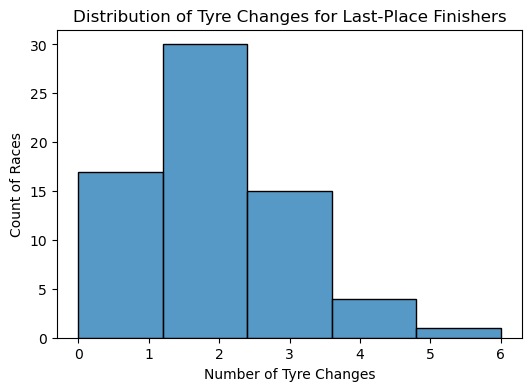

In [32]:
#Histogram
plt.figure(figsize=(6,4))
sns.histplot(last_counts["num_tyre_changes"], bins=5, kde=False)
plt.title("Distribution of Tyre Changes for Last-Place Finishers")
plt.xlabel("Number of Tyre Changes")
plt.ylabel("Count of Races")
plt.show()

In [45]:
# Aggregate table: average, std, count of position changes for each tyre transition
compound_summary = (
    tyre_weather
    .groupby("change_type")["position_change"]
    .agg(['median',"min", "std", "count",])
    .sort_values("median")   # sort by best improvement (most negative mean)
    .rename(columns={
        "mean": "avg_position_change",
        "std": "std_dev",
        "count": "num_occurrences"
    })
)

compound_summary



,median,min,std_dev,num_occurrences
change_type,,,,
SOFT->SOFT,0.00,-2.50,2.133619,111
HARD->SOFT,0.50,-2.00,2.766259,96
MEDIUM->MEDIUM,1.00,-4.00,3.381412,167
HARD->HARD,2.00,-3.25,2.512473,308
MEDIUM->SOFT,2.25,-4.25,2.668064,145
HARD->MEDIUM,3.00,-2.75,2.632341,276
SOFT->HARD,3.25,-2.25,2.933222,114
MEDIUM->HARD,3.50,-13.00,2.994811,733
SOFT->MEDIUM,4.00,-3.75,2.869222,147
